In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [4]:
# import helpers
from proj1_helpers import *

# all linear models
from linear_models.linear_reg_gd import * 
from linear_models.linear_reg_lsq import *
from linear_models.logistic_reg import *
from linear_models.ridge_reg_lsq import *

# preprocessing
from preprocess.imputer import *
from preprocess.scaler import *

In [63]:
# Import Data
DATA_TRAIN_PATH = '../data/train.csv' # download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH, sub_sample=True)

## Data Exploration

Let us explore the data and try to make sense of it!

In [7]:
print(y.shape, tX.shape, ids.shape)

(250000,) (250000, 30) (250000,)


There are:
- 250, 000 data points
- 30 different sets of features

#### There are more -1 values but the ratio is not too uneven.

In [8]:
import collections

freq = collections.Counter()
for x in y:
    freq[x] += 1
print(freq)

Counter({-1.0: 164333, 1.0: 85667})


In [10]:
HEADERS = ['Id', 'Prediction', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet',
       'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep',
       'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
       'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt',
       'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta',
       'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet',
       'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi',
       'PRI_jet_all_pt']

#### There are quite a number of undefined values in some of the columns!

In [13]:
def find_undefined():
    undefined_st = {}
    N, M = tX.shape
    for i in range(0, M): undefined_st[i] = 0
    for row in tX:
        for i in range(0, M):
            if row[i] == -999.0:
                undefined_st[i] += 1

    print("Undefined values for each feature: \n")
    for i in range(0, M):
        print("{0} : {1} / {2}".format(HEADERS[i+2], undefined_st[i], N - undefined_st[i]))
        
find_undefined()

Undefined values for each feature: 

DER_mass_MMC : 38114 / 211886
DER_mass_transverse_met_lep : 0 / 250000
DER_mass_vis : 0 / 250000
DER_pt_h : 0 / 250000
DER_deltaeta_jet_jet : 177457 / 72543
DER_mass_jet_jet : 177457 / 72543
DER_prodeta_jet_jet : 177457 / 72543
DER_deltar_tau_lep : 0 / 250000
DER_pt_tot : 0 / 250000
DER_sum_pt : 0 / 250000
DER_pt_ratio_lep_tau : 0 / 250000
DER_met_phi_centrality : 0 / 250000
DER_lep_eta_centrality : 177457 / 72543
PRI_tau_pt : 0 / 250000
PRI_tau_eta : 0 / 250000
PRI_tau_phi : 0 / 250000
PRI_lep_pt : 0 / 250000
PRI_lep_eta : 0 / 250000
PRI_lep_phi : 0 / 250000
PRI_met : 0 / 250000
PRI_met_phi : 0 / 250000
PRI_met_sumet : 0 / 250000
PRI_jet_num : 0 / 250000
PRI_jet_leading_pt : 99913 / 150087
PRI_jet_leading_eta : 99913 / 150087
PRI_jet_leading_phi : 99913 / 150087
PRI_jet_subleading_pt : 177457 / 72543
PRI_jet_subleading_eta : 177457 / 72543
PRI_jet_subleading_phi : 177457 / 72543
PRI_jet_all_pt : 0 / 250000


## Feature Processing

Let us make some modifications to the feature matrix, tX to make more reliable predictions

#### The steps we will be taking include:

1. Different y encoding [-1,1] vs [0,1] for linear regression and logistic regression respectively
2. Imputation of values using mode
3. Inverse Log transformation of positive columns
4. Polynomial Basis - feature expansion
5. Standardization

In [65]:
#different encoding just for logistic regression!
log_y = np.array(y, copy=True)
log_y[log_y==-1] = 0

In [14]:
# Create inverse log values of features which is positive in value.
def inverse_log_cols(X, X_test):
    inv_log_cols = (0,1,2,3,4,5,7,8,9,10,12,13,16,19,21,23,26)
    X_inv_log_cols = np.log(1 / (1 + X[:, inv_log_cols]))
    X = np.hstack((X, X_inv_log_cols))
    X_test_inv_log_cols = np.log(1 / (1 + X_test[:, inv_log_cols]))
    X_test = np.hstack((X_test, X_test_inv_log_cols))
    return X, X_test

In [15]:
# expands X by concatenating it with powers of itself (powers used are 2, 3 ... degree)
def build_poly(X, degree):
    ''' Polynomial basis functions from input data x '''
    N, M = X.shape
    for d in range(2, degree+1):
        for i in range(M):
            col = X[:, i]
            X = np.c_[X, np.power(col, d)]
    return X

In [21]:
def preprocess(X, X_test, degree, strategy="most frequent"):    
    # Impute -999 with a strategy - most frequent/median/mean
    imputer = Imputer(-999, strategy)
    X = imputer.fit_transform(X)
    X_test = imputer.transform(X_test)
    
    # Log transformation
    X, X_test = inverse_log_cols(X, X_test)
    
    # extend matrix
    X = build_poly(X, degree)
    X_test = build_poly(X_test, degree)
    
    # Normalize values
    scaler = Scaler()
    X = scaler.fit_transform(X)
    X_test = scaler.transform(X_test)
    
    return X, X_test

#### The function above will be called in before we train using our models!

## Cross Validation

It is quintesssential to do some validation on our end to access how our model is doing and to tune hyperparameters. We have to prepare a CV method that can be used for this!

In [20]:
def build_k_indices(num_row, k_fold):
    """build k indices for k-fold."""
    interval = int(num_row / k_fold)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval : (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [56]:
"""
Main function that does Cross-Validation. Explanation of parameters:

model : type of model to use
X : features
y : labels
degree : max degree for expansion with polynomial basis
assign_labels: function that assigns [-1,1] or [0,1] based on value/cutoff
k_fold: how much to split the data for cross validation, defaults to 4
seed: seed for randomization
cutoff: at what point do we want to assign 1 or -1/0
strategy: strategy for imputation of undefined/missin values
"""
def cross_validate(model, X, y, degree, assign_labels, k_fold=4, seed=1, cutoff=0, strategy="most frequent"):
    np.random.seed(seed) 
    k_indices = build_k_indices(y.shape[0], k_fold)
    test_acc = []
    train_acc = []
    
    def run_cv(k):
        k_test = k_indices[k]
        
        mask = np.ones(len(k_indices), dtype=bool)
        mask[[k]] = False
        k_train = k_indices[mask].ravel()
        
        X_train, y_train = X[k_train], y[k_train]
        X_test, y_test = X[k_test], y[k_test]
                
        X_train, X_test = preprocess(X_train, X_test, degree, strategy)
        
        model.fit(X_train, y_train)
  
        y_pred = assign_labels(model.predict(X_test), cutoff=cutoff)        
        test_acc.append(compute_accuracy(y_pred, y_test))
        
        y_pred_train = assign_labels(model.predict(X_train), cutoff=cutoff)
        train_acc.append(compute_accuracy(y_pred_train, y_train))
        
    for k in range(k_fold):
        run_cv(k)
    
    return np.array(train_acc), np.array(test_acc)

## Models/Strategy

In order to tackle this problem, we have chosen to go ahead with the Ridge Regression with normal equation and Logistic Regression using gradient descent. We have not used Linear Regression with gradient descent as the closed form gives us the best answer already.

## Initial Run

For starters, let us simply run our models with the existing features and see how they perform! 

In [57]:
seed = 60 #set a seed 

In [58]:
# use some magic numbers for the hyper parameters (will tune later)
lambda_ = 0.05
degree = 1

In [59]:
# note: exact same method as above with the preprocessing removed(this is for testing!)
def cross_validate_nopreprocess(model, X, y, degree, assign_labels, 
                                     k_fold=4, seed=1, cutoff=0, strategy="most frequent"):
    np.random.seed(seed) 
    k_indices = build_k_indices(y.shape[0], k_fold)
    test_acc = []
    train_acc = []
    
    def run_cv(k):
        k_test = k_indices[k]
        
        mask = np.ones(len(k_indices), dtype=bool)
        mask[[k]] = False
        k_train = k_indices[mask].ravel()
        
        X_train, y_train = X[k_train], y[k_train]
        X_test, y_test = X[k_test], y[k_test]
                        
        model.fit(X_train, y_train)
  
        y_pred = assign_labels(model.predict(X_test), cutoff=cutoff)        
        test_acc.append(compute_accuracy(y_pred, y_test))
        
        y_pred_train = assign_labels(model.predict(X_train), cutoff=cutoff)
        train_acc.append(compute_accuracy(y_pred_train, y_train))
        
    for k in range(k_fold):
        run_cv(k)
    
    return np.array(train_acc), np.array(test_acc)

RidgeRegressionLS: Train Accuracy:0.740 (+/- 0.000978), Test Accuracy:0.740 (+/- 0.001865)
LogisticRegression: Train Accuracy:0.639 (+/- 0.000564), Test Accuracy:0.639 (+/- 0.001681)


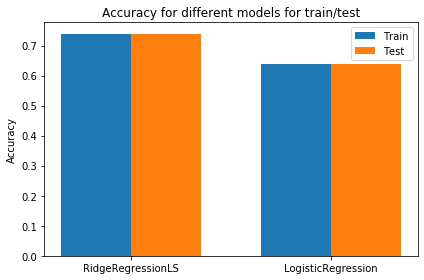

In [61]:
# for plotting
headers = ["RidgeRegressionLS", "LogisticRegression"]

# our models
models = [RidgeRegressionLS(lambda_=lambda_), LogisticRegression(lambda_=lambda_)]  

# cutoff for choosing the 1/-1 or 1/0 split
cutoffs = [0, 0.5]

# y values
y_i = [y, log_y]

# label the values with this
labeller = [predict_labels, predict_labels_01]

# for collecting the results
train_acc_list = []
test_acc_list = []

for i, model in enumerate(models):
    train_acc, test_acc = cross_validate_nopreprocess(model, tX, y_i[i], degree=degree, assign_labels=labeller[i], 
                                         seed=seed, cutoff=cutoffs[i])
    print("{0}: Train Accuracy:{1:.3f} (+/- {2:.6f}), Test Accuracy:{3:.3f} (+/- {4:.6f})".format(
        headers[i], train_acc.mean(), train_acc.std() * 2, test_acc.mean(), test_acc.std() * 2))
    
    train_acc_list.append(train_acc.mean())
    test_acc_list.append(test_acc.mean())
    
plot_bar_graph(headers, train_acc_list, test_acc_list, "Train", "Test", "Accuracy", 
               "Accuracy for different models for train/test")

#### Ridge Regression has a pretty decent performance while logistic regression does really poorly! This is a classification problem after all so logistic regression should perform better! Let's see what happens after preprocessing/adjusting hyperparameters 

## Tune Hyperparameters

Before we test our models on the processed feature matrix, it is important to adjust some of our hyperparameters that we are going to be using! This way we can be more confident that our model is reliable.


We will be plotting some graphs and adjusting the hyper-parameters by hand

#### Lets adjust degree and lambda_ for Ridge Regression 

0.7758813333333332 / 0.7758399999999999
0.7996488888888889 / 0.799452
0.8076093333333333 / 0.80718
0.813731111111111 / 0.813316
0.816959111111111 / 0.816588
0.8181822222222221 / 0.8177559999999999
0.8189715555555555 / 0.818592
0.819616888888889 / 0.8193199999999999
0.8200924444444444 / 0.8198359999999999
0.8202075555555556 / 0.819996
0.820392 / 0.8201039999999999


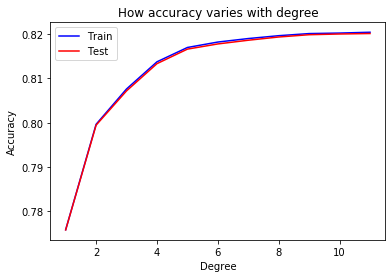

In [43]:
lambda_ = 1e-10
degrees = [i for i in range(1, 12)]

model = RidgeRegressionLS(lambda_=lambda_)

train_acc_set = []
test_acc_set = []

for degree in degrees:
    train_acc, test_acc = cross_validate(model, tX, y, assign_labels=predict_labels, degree=degree, seed=seed)
    train_acc_set.append(train_acc.mean())
    test_acc_set.append(test_acc.mean())
    print("{0} / {1}".format(train_acc_set[-1], test_acc_set[-1]))
    
plot_line_graph("How accuracy varies with degree", 
                degrees, train_acc_set, test_acc_set, "Train", "Test", "Accuracy", "Degree")

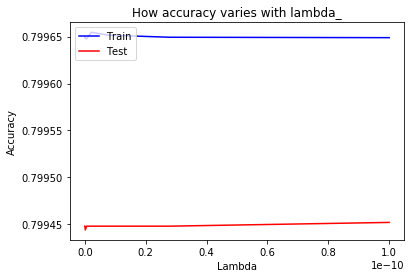

In [44]:
degree = 2
lambda_set = np.logspace(-15, -10, 10)

train_acc_set = []
test_acc_set = []

for lambda_ in lambda_set:
    model = RidgeRegressionLS(lambda_=lambda_)
    train_acc, test_acc = cross_validate(model, tX, y, assign_labels=predict_labels, degree=degree, seed=seed)
    train_acc_set.append(train_acc.mean())
    test_acc_set.append(test_acc.mean())

plot_line_graph("How accuracy varies with lambda_", 
                lambda_set, train_acc_set, test_acc_set, "Train", "Test", "Accuracy", "Lambda")

Findings: lambda_ = 1e-10 and degree = 10 looks like it will give a good result for Ridge Regression

#### Note: This is by no means an exchaustive grid search (took too long to run)

#### Lets adjust degree, lambda_ and step_size for Ridge Regression 

In [ ]:
lambda_ = 0.006
degrees = [i for i in range(1, 4)]

model = LogisticRegression(lambda_=lambda_)

train_acc_set = []
test_acc_set = []

for degree in degrees:
    train_acc, test_acc = cross_validate(model, tX, log_y, assign_labels=predict_labels_01, degree=degree, seed=seed
                                         , strategy="mean")
    train_acc_set.append(train_acc.mean())
    test_acc_set.append(test_acc.mean())
    print("{0} / {1}".format(train_acc_set[-1], test_acc_set[-1]))
    
plot_line_graph("How accuracy varies with degree", 
                degrees, train_acc_set, test_acc_set, "Train", "Test", "Accuracy", "Degree")

In [ ]:
degree = 2
lambda_set = np.logspace(-10, -6, 10)

train_acc_set = []
test_acc_set = []

for lambda_ in lambda_set:
    model = LogisticRegression(lambda_=lambda_)
    train_acc, test_acc = cross_validate(model, tX, log_y, assign_labels=predict_labels_01, degree=degree, seed=seed)
    train_acc_set.append(train_acc.mean())
    test_acc_set.append(test_acc.mean())

plot_line_graph("How accuracy varies with lambda_", 
                lambda_set, train_acc_set, test_acc_set, "Train", "Test", "Accuracy", "Lambda")

Code takes a long time to run! We have deduced the optimal values to be 0.08 for step_size / 2 for degree / 0.05 from lambda_ after trying out a few samples manually. The above functions took too long to run.

#### Note: Similar to above, this was deduced by hand, there is probably a better combination at higher degrees

## Results

Now that we have a better idea of what hyperparameters to use, lets try to do the processing of features and check to see what is our final result 

RidgeRegressionLS: Train Accuracy:0.843 (+/- 0.008062), Test Accuracy:0.813 (+/- 0.007950)
LogisticRegression: Train Accuracy:0.834 (+/- 0.003908), Test Accuracy:0.824 (+/- 0.016871)


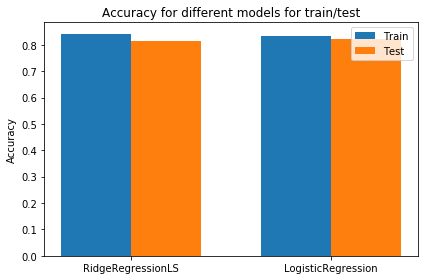

In [66]:
# for plotting
headers = ["RidgeRegressionLS", "LogisticRegression"]

# our models
models = [RidgeRegressionLS(lambda_=1e-10), LogisticRegression(lambda_=0.005)]  

# cutoff for choosing the 1/-1 or 1/0 split
cutoffs = [0, 0.5]

# y values
y_i = [y, log_y]

# optimal degrees
degree_i = [10, 2]

# label the values with this
labeller = [predict_labels, predict_labels_01]

# for collecting the results
train_acc_list = []
test_acc_list = []

for i, model in enumerate(models):
    train_acc, test_acc = cross_validate(model, tX, y_i[i], degree=degree_i[i], assign_labels=labeller[i], 
                                         seed=seed, cutoff=cutoffs[i])
    print("{0}: Train Accuracy:{1:.3f} (+/- {2:.6f}), Test Accuracy:{3:.3f} (+/- {4:.6f})".format(
        headers[i], train_acc.mean(), train_acc.std() * 2, test_acc.mean(), test_acc.std() * 2))
    
    train_acc_list.append(train_acc.mean())
    test_acc_list.append(test_acc.mean())
    
plot_bar_graph(headers, train_acc_list, test_acc_list, "Train", "Test", "Accuracy", 
               "Accuracy for different models for train/test")

#### The processing and hyperparameter tuning works! 

Both models have much better accuracy now and logistic regression is doing as well as expected.

#### Note: The models were trained using a sub-sample as it took too long to train on full set

## Generate predictions and save ouput in csv format for submission:

In [67]:
# final ridge regression model
def ridge_reg_solver(tX, y, tX_test):
    lambda_ = 1.00000000e-10
    degree = 15
    model = RidgeRegressionLS(lambda_=lambda_)    
    tX, tX_test = preprocess(tX, tX_test, degree)         
    model.fit(tX, y)
    y_pred = predict_labels(model.predict(tX_test))
    return y_pred

In [68]:
# final log reg solver
def log_reg_solver(tX, y, tX_test):
    lambda_ = 0.00006
    degree = 2
    model = LogisticRegression(lambda_=lambda_)
    tX, tX_test = preprocess(tX, tX_test, degree) 
    model.fit(tX, y)
    y_pred = predict_labels_01(model.predict(tX_test))
    y_pred[y_pred==0] = -1
    return y_pred

## Final Model


In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = 'pred.csv'

In [ ]:
create_csv_submission(ids_test, ridgeRegSolver(tX, y, tX_test) ,OUTPUT_PATH)

In [ ]:
create_csv_submission(ids_test, logRegSolver(tX, log_y, tX_test) ,OUTPUT_PATH)